# Face Mask Detection

## Data Preprocessing

In [69]:
# Import Libraries
import numpy as np
import pandas as pd
import cv2
import time
import os
import gc
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

## Importing & Labeling Images

In [70]:
# Importing Correctly & Incorrectly Worn Mask Images
dirs = os.listdir('D:/tuansihan/06 Projects/08 Face Mask Detection System/images')
images_path = []
labels = []

for folder in dirs:
    path = glob('D:/tuansihan/06 Projects/08 Face Mask Detection System/images/{}/*.jpg'.format(folder))
    label = ['{}'.format(folder)]*len(path)
    
    images_path.extend(path)
    labels.extend(label)

In [71]:
np.unique(labels)

array(['Chin Uncovered', 'Covered', 'Nose & Mouth Uncovered',
       'Nose Uncovered'], dtype='<U22')

In [72]:
labels.count('Chin Uncovered')

3000

In [73]:
# print(images_path[1005])

## Implementing Face Detection

In [74]:
# # Trying to detect 1 image
# img_path = images_path[9501]
# img = cv2.imread(img_path)

In [75]:
# # cv2.imshow('Actual Image', img)
# # cv2.waitKey()
# # cv2.destroyAllWindows()
# plt.imshow(img)
# print(labels[9501])

In [76]:
# Loading Face Detection Model
fd_model = cv2.dnn.readNetFromCaffe('D:/tuansihan/06 Projects/08 Face Mask Detection System/models/deploy.prototxt.txt',
                                    'D:/tuansihan/06 Projects/08 Face Mask Detection System/models/res10_300x300_ssd_iter_140000_fp16.caffemodel')

In [84]:
def face_detection(img):

    # Blob from Image
    # RGB Mean - Image

    image = img.copy()
    w, h = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1, (300, 300), (104, 117, 123), swapRB = True)
    
    # Input Detections
    fd_model.setInput(blob)
    detection = fd_model.forward()
    #print(detection)
    #detection.shape

    for i in range(0, detection.shape[2]):
        conf_score = detection[0, 0, i, 2]
        #print(conf_score)

        # Filtering Confidence > 50%
        if conf_score > 0.5:
            #print(conf_score)
            box = detection[0, 0, i, 3:7] * np.array([w, h, w, h])
            box = box.astype(int)
            #print(box)
            pt1 = (box[0], box[1])
            pt2 = (box[2], box[3])
            #cv2.rectangle(image, pt1, pt2, (0, 255, 0), 2)

            # Region of Interest
            roi = image[box[1]:box[3], box[0]:box[2]]
            return roi

        return None

    # cv2.imshow('Face Detected', image)
    # cv2.imshow('Region of Interest', roi)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

## Cropping The Face

In [78]:
# roi_img = face_detection(img)

In [79]:
# # cv2.imshow('Original Image', img)
# # cv2.imshow('Region of Interest', roi_img)
# # cv2.waitKey()
# # cv2.destroyAllWindows()
# plt.imshow(img)
# plt.show()
# plt.imshow(roi_img)

## Feature Extraction

In [80]:
def data_preprocess(img):

    # Blob From Image (RGB Mean - Image)
    face = face_detection(img)
    
    #Preprocessing should only be applied if face has value
    if face is not None:
        
        # Calculate Blob from Image
        blob = cv2.dnn.blobFromImage(face, 1, (100, 100), (104, 117, 123), swapRB=True)
        #print(blob.shape)

        # Compress blob (Reduce Dimension)
        compressed_blob = np.squeeze(blob).T #T -> Transpose (3, 100, 100 to 100, 100, 3)
        #print(compressed_blob.shape)

        # Rotate blob 90 degrees clockwise
        rotated_blob = cv2.rotate(compressed_blob, cv2.ROTATE_90_CLOCKWISE)

        # Flip blob horizontally
        flipped_blob = cv2.flip(rotated_blob, 1)

        # Check minimum and maxinmum value of image
        #flipped_blob.max(), flipped_blob.min()

        # Remove Negative Values from image
        img_no_neg = np.maximum(flipped_blob, 0) # Any values less than 0 would be replaced by 0

        # Normalize Image
        norm_img = img_no_neg/flipped_blob.max() #divide by maximum value

        return norm_img
    
    else:
        return None

In [81]:
# cv2.imshow('Region of Interest', face)
# cv2.namedWindow('Flipped Blob', cv2.WINDOW_NORMAL)
# cv2.imshow('Flipped Blob', flipped_blob)
# cv2.waitKey()
# cv2.destroyAllWindows()

## Prepare all Images into a List

In [82]:
len(images_path)

12000

In [85]:
#start = time.process_time()

img_data = []
img_labels = []
i = 0

for path, label in tqdm(zip(images_path, labels), desc = 'Preprocessing'):
    
    img = cv2.imread(path)
    processed_img = data_preprocess(img)
    
    if processed_img is not None:
        img_data.append(processed_img)
        img_labels.append(label)
        
    # Garbage Collection to clear temp memory
    i += 1
    if i%100 == 0:
        gc.collect()
        
#print(time.process_time() - start)

Preprocessing: 12000it [22:13,  9.00it/s]


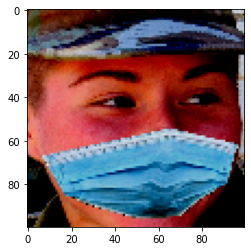

1


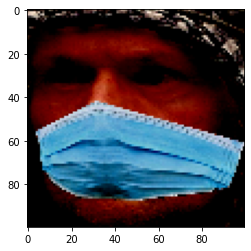

2


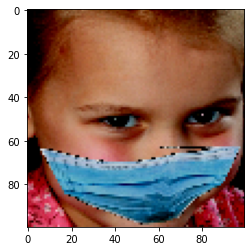

3


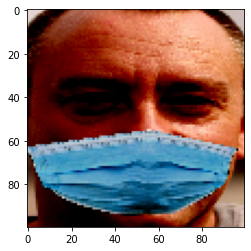

4


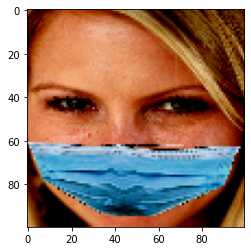

5


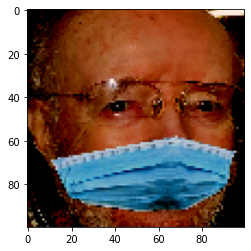

6


In [86]:
x = 0
for i in img_data:
    plt.imshow(i)
    plt.show()
    
    x+=1
    print (x)
    if x>5:
        break

In [87]:
# Converting lists to arrays
X = np.array(img_data)
y = np.array(img_labels)

In [88]:
X.shape, y.shape

((11940, 100, 100, 3), (11940,))

In [89]:
# Save X and y in NumPy Zip
np.savez('D:/tuansihan/06 Projects/08 Face Mask Detection System/data/preprocessed_data.npz', X, y)